In [1]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.homography import *
from keyrover import *

device = get_device()
device

2024-11-20 14:44:17.129 Python[9165:447622] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


'mps'

In [2]:
image_paths = get_dataset_paths()
len(image_paths)

4999

In [3]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([    0.26772,     0.28418,     0.28728]),
 array([    0.24712,      0.2489,     0.25881]))

In [4]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (256, 256)

train_dataset = KeyboardCameraTransformDataset(train_paths, size=SIZE)
valid_dataset = KeyboardCameraTransformDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

  0%|          | 0/4500 [00:00<?, ?it/s]

Error decoding JSON from /Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json. Starting with an empty dictionary.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2024-11-20 14:44:22.579 Python[9187:447805] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:22.735 Python[9184:447797] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:22.806 Python[9189:447811] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:23.253 Python[9188:447809] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:23.302 Python[9190:447818] WARNING: Secure coding is not enabled for restorable state! 

  0%|          | 0/499 [00:00<?, ?it/s]

2024-11-20 14:44:32.603 Python[9238:448241] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:32.603 Python[9233:448227] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:32.635 Python[9237:448238] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:32.647 Python[9236:448235] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-20 14:44:32.810 Python[9240:448249] WARNING: Secure coding is not enabled for restorable state! 

(4500, 499)

In [5]:
train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

Target: tensor([ 0.1743, -0.5156, -0.5307, -0.0572, -0.1950, -1.6633])
Image: tensor(-1.1100) tensor(2.9631)


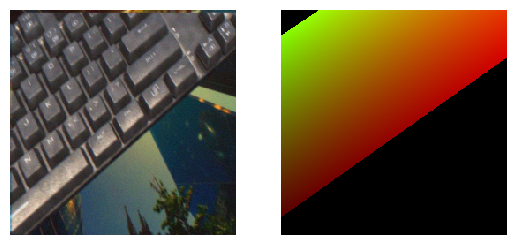

In [6]:
img, target = train_dataset.random_img()
print("Target:", target)
print("Image:", img.min(), img.max())

mean = torch.tensor([0.29174, 8.5515e-06, 0.023512, -0.20853, -0.80377, 3.3909], device=device)
std = torch.tensor([0.14669, 0.047459, 1.1898, 0.9208, 0.71566, 0.85268], device=device)

target = target.unsqueeze(0).to(device) * std + mean
texcoords = prediction_to_texture_coordinates(target)
imshow(img, texcoords[0])

In [44]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [8]:
from torchvision import models


class CornersRegressionModel(pl.LightningModule):
    def __init__(self, lr: float | None = None) -> None:
        super().__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze the parameters of the pre-trained layers
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # Unfreeze the parameters of the last few layers for fine-tuning
        # for param in self.model.layer4.parameters():
        #     param.requires_grad = True

        self.loss_fn = torch.nn.MSELoss()

        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(self.model.fc.in_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 6),
        )

        self.learning_rate = lr
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def predict(self, image: torch.Tensor) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self.forward(image)
        pred = prediction_to_texture_coordinates(pred)

        if len(pred) == 1:
            return pred[0,]
        return pred

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return self.model(image)

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        image, target = batch
        predictions = self.model(image)

        loss = self.loss_fn(predictions, target)
        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "val")

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "test")

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [36]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [41]:
LEARNING_RATE = 1e-4

wandb.finish()
model = CornersRegressionModel(lr=LEARNING_RATE)
model

CornersRegressionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [42]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.3 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.302    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode

In [ ]:
logger = WandbLogger(project="mrover-keyboard-corner-prediction")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [46]:
torch.save(model.state_dict(), f"models/transform-prediction/{wandb.run.name}.pt")

In [9]:
model = CornersRegressionModel()
model.load_state_dict(torch.load(f"models/transform-prediction/balmy-sponge-6.pt", weights_only=True))

<All keys matched successfully>

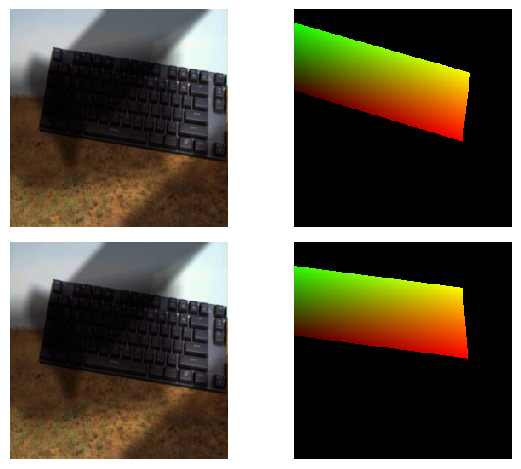

In [46]:
model.to(device)
model.eval()

image, target = valid_dataset.random_img()
image = image.to(device).unsqueeze(0)
target = target.to(device).unsqueeze(0)

with torch.no_grad():   
    pred = model(image)

pred = (pred * std + mean)
target = (target * std + mean)

pred = prediction_to_texture_coordinates(pred)
target = prediction_to_texture_coordinates(target)

show_images([image[0], pred[0], image[0], target[0]])

150


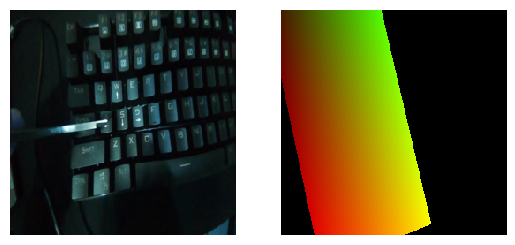

In [49]:
vidcap = cv2.VideoCapture(f"{TEST_DATASET}/110.mp4")
total = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
frame = 150
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
_, image = vidcap.read()

image = test_transforms(image).unsqueeze(0)
image = image.to(device)

with torch.no_grad():
    pred = model(image)

pred = (pred * std + mean)
pred = prediction_to_texture_coordinates(pred)

imshow(image[0], pred[0])

In [153]:
print(image.min(), image.max())
image.shape

tensor(-1.0834, device='mps:0') tensor(2.9316, device='mps:0')


torch.Size([1, 3, 256, 256])